In [50]:
import sys
sys.path.insert(0, '../Utilities/')

import torch
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings

warnings.filterwarnings('ignore')

np.random.seed(1234)

In [51]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("gpu")
else:
    device = torch.device('cpu')

gpu


In [52]:
class SineLayer(torch.nn.Module):
    def __init__(self, w0):
        super(SineLayer, self).__init__()
        self.w0 = w0    # this is the frequency of the sine wave

    def forward(self,x):
        return torch.sin(self.w0*x)
    
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, SineLayer(3)))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [53]:
# the physics-guided neural network
def calc_grad(y, x) -> torch.Tensor:
        grad = torch.autograd.grad(
            outputs=y,
            inputs=x,
            grad_outputs=torch.ones_like(y),
            create_graph=True,
            retain_graph=True,
        )[0]
        return grad

        
class PhysicsInformedNN():
    def __init__(self, X, u, Xt, layers):
    
        
        # data
        self.x = torch.tensor(X[:, 0], requires_grad=True).float().to(device)
        self.y = torch.tensor(X[:, 1], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)

        self.xt = torch.tensor(Xt[:, 0], requires_grad=True).float().to(device)
        self.yt = torch.tensor(Xt[:, 1], requires_grad=True).float().to(device)
        

        self.dnn = DNN(layers).to(device)

        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-6, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"    
        )
        
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.stack([x, t], dim=1))
        return u
    
    
    
    def net_f(self, x, y):

        Re = 500
        Sc = 0.7

        output = self.net_u(x, y)
        p_pred = output[:, 2]
        u_pred = output[:, 0]
        v_pred = output[:, 1]
        Y_i_pred = output[:, 3]

        u_x = calc_grad(u_pred, x)
        u_y = calc_grad(u_pred, y)
        u_xx = calc_grad(u_x, x)
        u_yy = calc_grad(u_y, y)

        v_x = calc_grad(v_pred, x)
        v_y = calc_grad(v_pred, y)
        v_xx = calc_grad(v_x, x)
        v_yy = calc_grad(v_y, y)

        Y_i_x = calc_grad(Y_i_pred, x)
        Y_i_y = calc_grad(Y_i_pred, y)
        Y_i_xx = calc_grad(Y_i_x, x)
        Y_i_yy = calc_grad(Y_i_y, y)

        p_x = calc_grad(p_pred, x)
        p_y = calc_grad(p_pred, y)

        continuity = u_x + v_y
        f_u = u_pred*u_x + v_pred*u_y + p_x - (u_xx + u_yy)/Re
        f_v = u_pred*v_x + v_pred*v_y + p_y - (v_xx + v_yy)/Re
        f_Y_i = u_pred*Y_i_x + v_pred*Y_i_y - (Y_i_xx + Y_i_yy)/(Re*Sc)

        
        return continuity, f_u, f_v, f_Y_i
    
    def loss_func(self):
        u_pred = self.net_u(self.x, self.y)
        cont, f_u_pred, f_v_pred, f_Y_i_pred = self.net_f(self.xt, self.yt)
        loss = torch.mean((self.u[:, 0] - u_pred[:, 0]) ** 2) + torch.mean((self.u[:, 1] - u_pred[:, 1]) ** 2) + \
                    torch.mean((self.u[:, 2] - u_pred[:, 3]) ** 2) + \
               0.1*(torch.mean(f_u_pred ** 2) + torch.mean( f_v_pred ** 2) + torch.mean( cont ** 2)) + \
                    0.01*(torch.mean(f_Y_i_pred ** 2))
        
        self.optimizer.zero_grad()
        loss.backward()
        
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Loss: %e' % 
                (
                    loss.item()
                )
            )
        return loss
    
    def train(self, nIter):
        self.dnn.train()
        # for epoch in range(nIter):
        self.optimizer.step(self.loss_func)
                
    
    def predict(self, X):
        x = torch.tensor(X[:, 0], requires_grad=True).float().to(device)
        y = torch.tensor(X[:, 1], requires_grad=True).float().to(device)

        self.dnn.eval()
        output = self.net_u(x, y)
        u_pred = output[:, 0]
        v_pred = output[:, 1]
        p_pred = output[:, 2]
        Y_i_pred = output[:, 3]
        return u_pred, v_pred, p_pred, Y_i_pred

## Configurations

In [54]:
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 4]


x = np.linspace(0, 1, 401)
y = np.linspace(0, 1, 401)

MG1 = np.meshgrid(x, y)
xf = MG1[0].flatten()
yf = MG1[1].flatten()

X_test = np.vstack([xf, yf]).T      
print(X_test.shape)

(160801, 2)


In [55]:
idx = []
for i in range(len(X_test)):
    if X_test[i][1] == 1:
            idx.append(X_test[i])
    elif X_test[i][0] == 0 and X_test[i][1] != 1 and i%2 == 0:
            idx.append(X_test[i])
    elif X_test[i][0] == 1 and X_test[i][1] != 1 and i%2 == 0:
            idx.append(X_test[i])
    elif ((X_test[i][1] == 0 and X_test[i][0] != 1) or (X_test[i][1] == 0 and X_test[i][0] != 0)) and i%2 == 0:
            idx.append(X_test[i])
    
u = []
for i in range(len(idx)):
    if idx[i][1] == 1:
        u.append([1, 0, 1])
    elif idx[i][0] == 0 and idx[i][1] != 1:
        u.append([0, 0, 0])
    elif idx[i][0] == 1 and idx[i][1] != 1:
         u.append([0, 0, 0])
    elif (idx[i][1] == 0 and idx[i][0] != 1) or (idx[i][1] == 0 and idx[i][0] != 0):
         u.append([0, 0, 0])

idx = np.array(idx)
u_training = np.array(u)

X_u_train = np.vstack([idx[:, 0], idx[:, 1]]).T
u_train = np.vstack((u_training[:, 0], u_training[:, 1], u_training[:, 2])).T 
print(X_u_train.shape)

# fig = plt.figure(figsize = (10, 7))
# ax = plt.axes(projection ="3d")
# ax.scatter3D(X_u_train[:, 0], X_u_train[:, 1], u_train[:, 0], color = "green")
# plt.title("simple 3D scatter plot")

# plt.scatter(X_u_train[:, 0], X_u_train[:, 1], c ="blue", s = 1)
# plt.show()


(1000, 2)


In [56]:
model = PhysicsInformedNN(X_u_train, u_train, X_test, layers)
model.train(0)

Loss: 8.186772e-03
Loss: 6.275364e-03
Loss: 5.386600e-03
Loss: 4.896959e-03
Loss: 4.502018e-03
Loss: 4.198796e-03
Loss: 3.970318e-03
Loss: 3.782858e-03
Loss: 3.585546e-03
Loss: 3.431371e-03
Loss: 3.253382e-03
Loss: 3.034831e-03
Loss: 2.802029e-03
Loss: 2.521947e-03
Loss: 2.220839e-03
Loss: 1.981166e-03
Loss: 1.792886e-03
Loss: 1.637735e-03
Loss: 1.492386e-03
Loss: 1.381452e-03
Loss: 1.290338e-03
Loss: 1.184073e-03
Loss: 1.073042e-03
Loss: 9.784028e-04
Loss: 9.112256e-04
Loss: 8.577965e-04
Loss: 8.000555e-04
Loss: 7.639371e-04
Loss: 7.273077e-04
Loss: 6.953048e-04
Loss: 6.629745e-04
Loss: 6.351639e-04
Loss: 6.003533e-04
Loss: 5.744096e-04
Loss: 5.504427e-04
Loss: 5.233452e-04
Loss: 5.026369e-04
Loss: 4.847728e-04
Loss: 4.651760e-04
Loss: 4.433104e-04
Loss: 4.204029e-04
Loss: 3.966028e-04
Loss: 3.756110e-04
Loss: 3.560123e-04
Loss: 3.392767e-04
Loss: 3.254041e-04
Loss: 3.129027e-04
Loss: 3.012702e-04
Loss: 2.898738e-04
Loss: 2.781410e-04
Loss: 2.678384e-04
Loss: 2.593825e-04
Loss: 2.5242

In [57]:
u_pred, v_pred, p_pred, Y_i_pred = model.predict(X_test)
preds =  torch.stack([u_pred, v_pred, p_pred, Y_i_pred], dim=1)
preds = preds.detach().cpu().numpy()
U_pred = griddata(X_test, preds[:, 0].flatten(), (MG1[0], MG1[1]), method='cubic')
V_pred = griddata(X_test, preds[:, 1].flatten(), (MG1[0], MG1[1]), method='cubic')
P_pred = griddata(X_test, preds[:, 2].flatten(), (MG1[0], MG1[1]), method='cubic')
Y_I_pred = griddata(X_test, preds[:, 3].flatten(), (MG1[0], MG1[1]), method='cubic')

In [58]:
u_pred = preds[:, 0]
v_pred = preds[:, 1]
p_pred = preds[:, 2]
Y_i_pred = preds[:, 3]

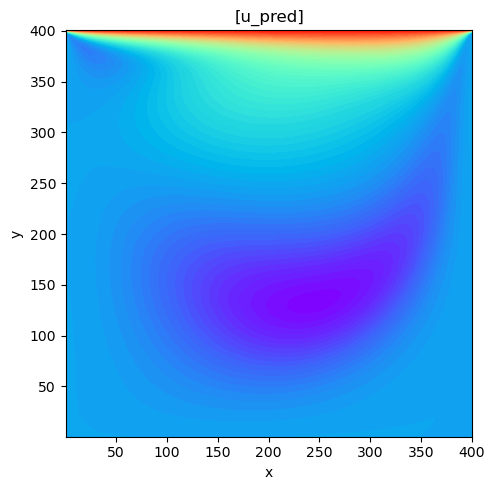

In [59]:
n = 401
fig = plt.figure(figsize=(20, 5))
con_lv = 100
ax1 = fig.add_subplot(1, 1, 1)
_u = u_pred.reshape(n, n)
contour1 = ax1.contourf(_u, con_lv, origin='lower', cmap='rainbow', aspect='auto')
ax1.set_aspect('equal')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('[u_pred]')

plt.tight_layout()
plt.show()


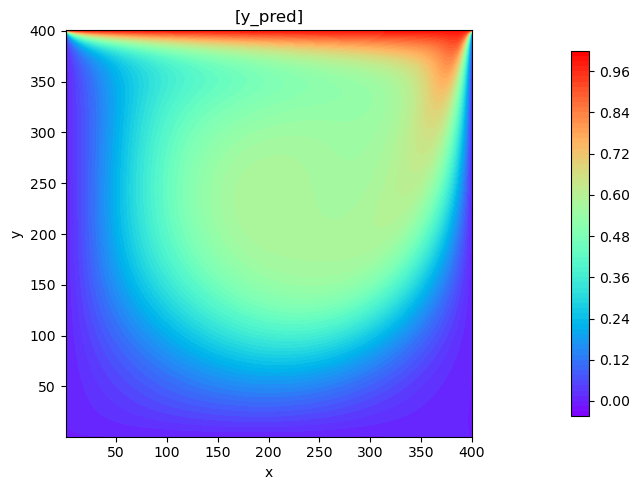

In [60]:
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 1, 1)
_y = Y_i_pred.reshape(n ,  n)
contour1 = ax1.contourf(_y, con_lv, origin='lower', cmap='rainbow', aspect='auto')
ax1.set_aspect('equal')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
fig.colorbar(contour1, ax=ax1, shrink=0.9)
ax1.set_title('[y_pred]')

plt.tight_layout()
plt.show()


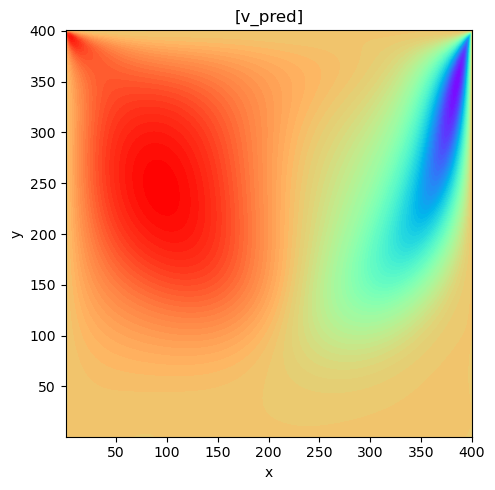

In [61]:
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 1, 1)
_v = v_pred.reshape(n ,  n)
contour1 = ax1.contourf(_v, con_lv, origin='lower', cmap='rainbow', aspect='auto')
ax1.set_aspect('equal')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('[v_pred]')

plt.tight_layout()
plt.show()


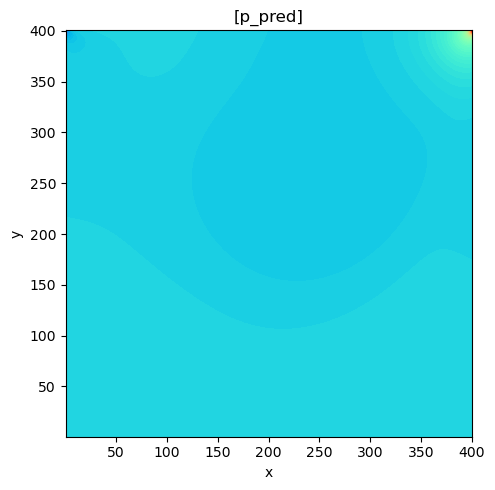

In [62]:
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 1, 1)
_p = p_pred.reshape(n ,n)
contour1 = ax1.contourf(_p, con_lv, origin='lower', cmap='rainbow', aspect='auto')
ax1.set_aspect('equal')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('[p_pred]')

plt.tight_layout()
plt.show()


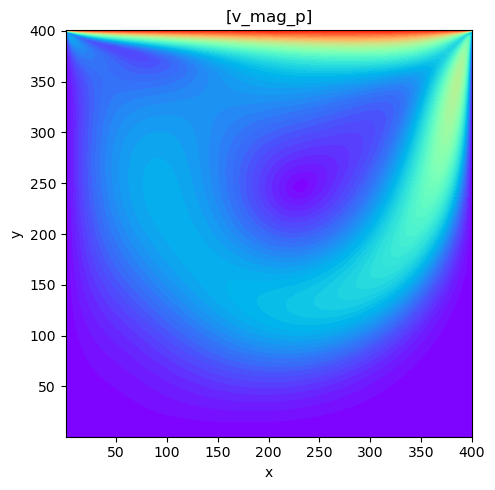

In [63]:
fig = plt.figure(figsize=(20, 5))
v_mag = np.sqrt(u_pred**2 + v_pred**2)
ax1 = fig.add_subplot(1, 1, 1)
_V = v_mag.reshape(n, n)
contour1 = ax1.contourf(_V, con_lv, origin='lower', cmap='rainbow', aspect='auto')
ax1.set_aspect('equal')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('[v_mag_p]')

plt.tight_layout()
plt.show()
